# Predicting Chicago Crime
The outline for the notebook is as follows:
1. Introduction to Dataset
2. Data Preparation
3. Preliminary Analysis 
4. Creating Models
5. Tuning Models
6. Testing on Holdout

## Section 1: Introduction to Dataset
The [dataset](https://data.cityofchicago.org/Public-Safety/Crimes-2001-to-present/ijzp-q8t2) analyzed below is a record of the the crimes of Chicago from 2001 to the present. This data is extracted directly from the Chicago Police Department's CLEAR (Citizen Law Enforcement Analysis and Reporting) system and is updated daily; this data is provided in CSV form. 

In this dataset each row is a reported crime (6.92 million crimes reported) and each column is a feature of the crime. The 22 features include:
1. **ID**: Unique identifier for the record.
2. **Case Number**: The Chicago Police Department RD Number (Records Division Number), which is unique to the incident.
3. **Date**: Date and time when the incident occurred (sometimes a best estimate)
4. **Block**: The partially redacted address where the incident occurred, placing it on the same block as the actual address.
5. **IUCR**: The Illinois Unifrom Crime Reporting code. This is directly linked to the Primary Type and Description. See the list of IUCR codes at https://data.cityofchicago.org/d/c7ck-438e.
6. **Primary Type**: The primary description of the IUCR code.
7. **Description**: The secondary description of the IUCR code, a subcategory of the primary description.
8. **Location Description**: Description of the location where the incident occurred.
9. **Arrest**: Indicates whether an arrest was made.
10. **Domestic**: Indicates whether the incident was domestic-related as defined by the Illinois Domestic Violence Act.
11. **Beat**: Indicates the beat where the incident occurred. A beat is the smallest police geographic area – each beat has a dedicated police beat car. Three to five beats make up a police sector, and three sectors make up a police district. The Chicago Police Department has 22 police districts. See the beats at https://data.cityofchicago.org/d/aerh-rz74.
12. **District**: Indicates the police district where the incident occurred. See the districts at https://data.cityofchicago.org/d/fthy-xz3r.
13. **Ward**: The ward (City Council district) where the incident occurred. See the wards at https://data.cityofchicago.org/d/sp34-6z76.
14. **Community Area**: Indicates the community area where the incident occurred. Chicago has 77 community areas. See the community areas at https://data.cityofchicago.org/d/cauq-8yn6.
15. **FBI Code**: Indicates the crime classification as outlined in the FBI's National Incident-Based Reporting System (NIBRS). See the Chicago Police Department listing of these classifications at http://gis.chicagopolice.org/clearmap_crime_sums/crime_types.html.
16. **X Coordinate**: The x coordinate of the location where the incident occurred in State Plane Illinois East NAD 1983 projection. This location is shifted from the actual location for partial redaction but falls on the same block.
17. **Y Coordinate**: The y coordinate of the location where the incident occurred in State Plane Illinois East NAD 1983 projection. This location is shifted from the actual location for partial redaction but falls on the same block.
18. **Year**: Year the incident occurred
19. **Updated On**: Date and time the record was last updated.
20. **Latitude**: The latitude of the location where the incident occurred. This location is shifted from the actual location for partial redaction but falls on the same block.
21. **Longitude**: The longitude of the location where the incident occurred. This location is shifted from the actual location for partial redaction but falls on the same block.
22. **Location**: The location where the incident occurred in a format that allows for creation of maps and other geographic operations on this data portal. This location is shifted from the actual location for partial redaction but falls on the same block.

## Section 2: Data Preparation

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from scipy import stats

import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_absolute_error

In [2]:
# Loading crime data
df = pd.read_csv('Crimes_-_2001_to_present.csv')

print(df.shape)
df.head()

(6915166, 30)


,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Longitude,Location,Historical Wards 2003-2015,Zip Codes,Community Areas,Census Tracts,Wards,Boundaries - ZIP Codes,Police Districts,Police Beats
0,11749937,JC339302,07/07/2019 11:58:00 PM,002XX W 63RD ST,1330,CRIMINAL TRESPASS,TO LAND,CTA STATION,True,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,11749976,JC339278,07/07/2019 11:55:00 PM,004XX W 61ST ST,0486,BATTERY,DOMESTIC BATTERY SIMPLE,STREET,False,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,11749909,JC339323,07/07/2019 11:54:00 PM,020XX E 67TH ST,3731,INTERFERENCE WITH PUBLIC OFFICER,OBSTRUCTING IDENTIFICATION,STREET,True,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,11750967,JC340456,07/07/2019 11:50:00 PM,023XX W DICKENS AVE,0890,THEFT,FROM BUILDING,RESIDENCE,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,11749898,JC339320,07/07/2019 11:49:00 PM,076XX N MARSHFIELD AVE,2024,NARCOTICS,POSS: HEROIN(WHITE),STREET,True,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
# Observing types of data, unique, NaN, and sample in all features
def fast_uniques(dataframe):
    '''Nested function for more efficient way of finding unique values.'''
    empty_list = []
    for column in dataframe.columns:
        if df[column].nunique() > 1000:
            answer = '1000+'
        else:
            answer = df[column].nunique()
        empty_list.append(answer)
    return empty_list

def snapshot(data):
    '''Creates df with snapshot of original df for cleaning and analysis.'''
    preliminary_details = pd.DataFrame()
    preliminary_details['Type'] = data.dtypes
    preliminary_details['Unique'] = fast_uniques(data)
    preliminary_details['NaN'] = data.isnull().sum()
    preliminary_details['Sample'] = data.sample().T
    return preliminary_details

snapshot(df)

,Type,Unique,NaN,Sample
ID,int64,1000+,0,1983123
Case Number,object,1000+,4,HH174708
Date,object,1000+,0,01/15/2002 12:00:00 PM
Block,object,1000+,0,022XX W MORSE AV
IUCR,object,402,0,0841
Primary Type,object,35,0,THEFT
Description,object,380,0,FINANCIAL ID THEFT:$300 &UNDER
Location Description,object,179,5237,APARTMENT
Arrest,bool,2,0,False
Domestic,bool,2,0,False


In [4]:
# Removing features that don't provide additional insight
df = df.drop(['FBI Code',          # information provided in IUCR
              'Updated On',        # does not add value
              'Latitude',          # stored in Location (with greater accuracy)
              'Longitude',         # stored in Location (with greater accuracy) 
              'Historical Wards 2003-2015'], # provided in Wards
             axis=1
            )

In [5]:
# Creating function to change hour feature
def calculate_military_time(entry):
    '''Function changes normal hour time to military hour time.'''
    if entry[11:13] == '12':
        if entry[-2:] == 'PM':
            return('12')
        else:
            return('00')
    elif entry[-2:] == 'PM':
        return(str(int(entry[11:13]) + 12))
    else:
        return(str(entry[11:13]))

In [6]:
# Creating lists and appending them with appropriate values from "Date" feature
month = []
day = []
hour = []
minute = []

for entry in df.Date:
    month.append(entry[0:2])
    day.append(entry[3:5])
    hour.append(calculate_military_time(entry))
    minute.append(entry[14:16])

In [7]:
# Adding new features to DataFrame
df['Month'] = month
df['Day'] = day
df['Hour'] = hour
df['Minute'] = minute

# Removing feature
df = df.drop(['Date'], axis=1)

In [8]:
# Reversing "Day" feature in order to create day of week feature
reverse_chronological = df.Day[::-1]
days = ['Sun','Mon','Tues','Wed','Thur','Fri','Sat']

# Creating 'for loop' to label entries with appropriate weekday 
# (pd.to_datetime was too inefficient)
counter = 6
day_of_week = []

for entry in range(len(reverse_chronological)):
    if entry == 0:
        day_of_week.append('Sat')
    elif reverse_chronological[entry] == reverse_chronological[entry-1]:
        day_of_week.append(days[counter])
    elif reverse_chronological[entry] != reverse_chronological[entry-1]:
        if counter == 6:
            counter = 0
            day_of_week.append(days[counter])
        else:
            counter += 1
            day_of_week.append(days[counter])
    else:
        print('There was an error!')
        break

# Adding feature to DataFrame
df['weekday'] = day_of_week

In [9]:
# Removing warning
pd.options.mode.chained_assignment = None  # default='warn'

# Changing numbers into neighborhoods
neighborhoods = {1:'ROGERS PARK', 2:'WEST RIDGE', 3:'UPTOWN', 
                 4:'LINCOLN SQUARE', 5:'NORTH CENTER', 6:'LAKE VIEW', 
                 7:'LINCOLN PARK', 8:'NEAR NORTH SIDE', 9:'EDISON PARK', 
                 10:'NORWOOD PARK', 11:'JEFFERSON PARK', 12:'FOREST GLEN',
                 13:'NORTH PARK', 14:'ALBANY PARK', 15:'PORTAGE PARK', 
                 16:'IRVING PARK', 17:'DUNNING', 18:'MONTCLARE', 
                 19:'BELMONT CRAGIN', 20:'HERMOSA', 21:'AVONDALE', 
                 22:'LOGAN SQUARE', 23:'HUMBOLDT PARK', 24:'WEST TOWN', 
                 25:'AUSTIN', 26:'WEST GARFIELD PARK', 27:'EAST GARFIELD PARK', 
                 28:'NEAR WEST SIDE', 29:'NORTH LAWNDALE', 30:'SOUTH LAWNDALE', 
                 31:'LOWER WEST SIDE', 32:'LOOP', 33:'NEAR SOUTH SIDE', 
                 34:'ARMOUR SQUARE', 35:'DOUGLAS', 36:'OAKLAND', 
                 37:'FULLER PARK', 38:'GRAND BOULEVARD', 39:'KENWOOD', 
                 40:'WASHINGTON PARK', 41:'HYDE PARK', 42:'WOODLAWN', 
                 43:'SOUTH SHORE', 44:'CHATHAM', 45:'AVALON PARK', 
                 46:'SOUTH CHICAGO', 47:'BURNSIDE', 48:'CALUMET HEIGHTS', 
                 49:'ROSELAND', 50:'PULLMAN', 51:'SOUTH DEERING', 
                 52:'EAST SIDE', 53:'WEST PULLMAN', 54:'RIVERDALE', 
                 55:'HEGEWISCH', 56:'GARFIELD RIDGE', 57:'ARCHER HEIGHTS', 
                 58:'BRIGHTON PARK', 59:'MCKINLEY PARK', 60:'BRIDGEPORT', 
                 61:'NEW CITY', 62:'WEST ELSDON', 63:'GAGE PARK', 
                 64:'CLEARING', 65:'WEST LAWN', 66:'CHICAGO LAWN', 
                 67:'WEST ENGLEWOOD', 68:'ENGLEWOOD', 69:'GREATER GRAND CROSSING', 
                 70:'ASHBURN', 71:'AUBURN GRESHAM', 72:'BEVERLY', 
                 73:'WASHINGTON HEIGHTS', 74:'MOUNT GREENWOOD', 75:'MORGAN PARK', 
                 76:"O'HARE", 77:'EDGEWATER'
                }

# Filling miscellaneous Nan values with other feature
missing_values = df['Community Area'].isna()
df['Community Area'][missing_values] = df['Community Areas'][missing_values]

# Dropping irrelevant/mislabeled neighborhoods
df = df.drop(df['Community Area'][df['Community Area'] == 0.0].index)
df = df.drop(df['Community Area'][df['Community Area'].isna()].index)

df['Community Area'] = df['Community Area'].replace(neighborhoods)

In [10]:
# Checkpoint to see results
pd.set_option('display.max_columns', None)
df.head()

,ID,Case Number,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Community Area,X Coordinate,Y Coordinate,Year,Location,Zip Codes,Community Areas,Census Tracts,Wards,Boundaries - ZIP Codes,Police Districts,Police Beats,Month,Day,Hour,Minute,weekday
0,11749937,JC339302,002XX W 63RD ST,1330,CRIMINAL TRESPASS,TO LAND,CTA STATION,True,False,711,7.0,20.0,ENGLEWOOD,NaN,NaN,2019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,07,07,23,58,Sat
1,11749976,JC339278,004XX W 61ST ST,0486,BATTERY,DOMESTIC BATTERY SIMPLE,STREET,False,True,711,7.0,20.0,ENGLEWOOD,NaN,NaN,2019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,07,07,23,55,Sat
2,11749909,JC339323,020XX E 67TH ST,3731,INTERFERENCE WITH PUBLIC OFFICER,OBSTRUCTING IDENTIFICATION,STREET,True,False,331,3.0,5.0,WOODLAWN,NaN,NaN,2019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,07,07,23,54,Sat
3,11750967,JC340456,023XX W DICKENS AVE,0890,THEFT,FROM BUILDING,RESIDENCE,False,False,1432,14.0,32.0,LOGAN SQUARE,NaN,NaN,2019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,07,07,23,50,Sat
4,11749898,JC339320,076XX N MARSHFIELD AVE,2024,NARCOTICS,POSS: HEROIN(WHITE),STREET,True,False,2422,24.0,49.0,ROGERS PARK,NaN,NaN,2019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,07,07,23,49,Sat


## Section 3: Preliminary Analysis
### A. Crime Analysis

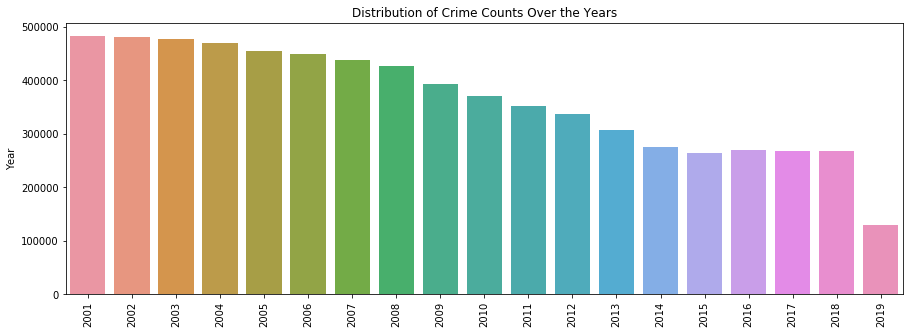

In [11]:
# Plotting frequency of crime per given year
plt.figure(figsize=[15,5])
g = sns.barplot(x=df['Year'].value_counts().index, y=df['Year'].value_counts())
plt.xticks(rotation=90)
plt.title('Distribution of Crime Counts Over the Years')
plt.show()

The downtrend of crime over the years is apparent (and commendable!) and will be kept in mind as we work on predicting future crime in Chicago over the next few months.

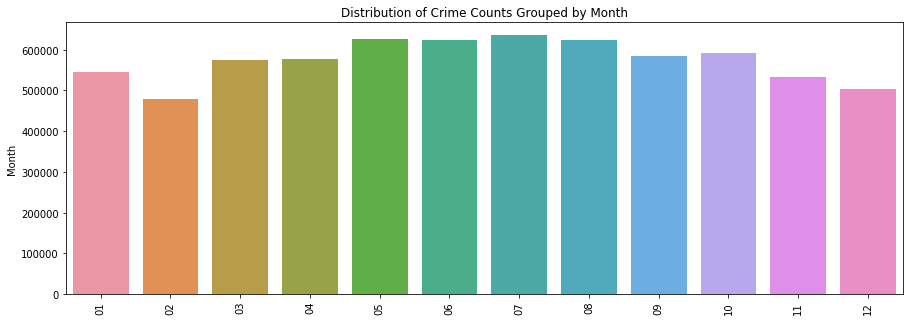

In [12]:
# Plotting frequency of crime per given month
plt.figure(figsize=[15,5])
g = sns.barplot(x=df['Month'].value_counts().index, y=df['Month'].value_counts())
plt.xticks(rotation=90)
plt.title('Distribution of Crime Counts Grouped by Month')
plt.show()

As will be shown later, the temperature correlates with crime activity which can account for the increase in crime during summer months as well as the decrease in crime during the colder months like February (although, it is interesting to note that January is still a very active crime month despite its colder weather). 

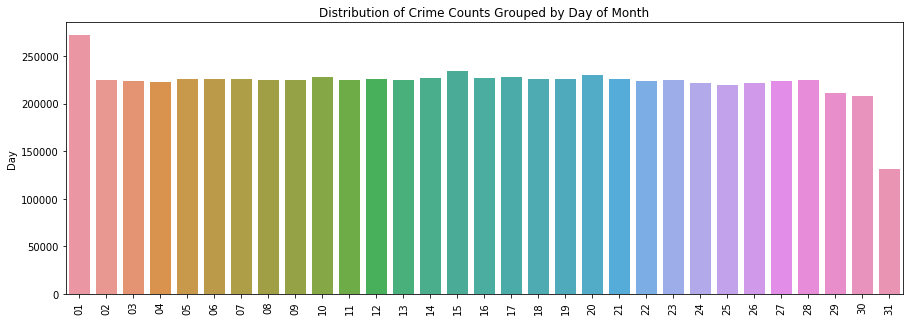

In [13]:
# Plotting frequency of crime per given day
plt.figure(figsize=[15,5])
g = sns.barplot(x=df['Day'].value_counts().index, y=df['Day'].value_counts())
plt.xticks(rotation=90)
plt.title('Distribution of Crime Counts Grouped by Day of Month')
plt.show()

In [14]:
# Viewing top crimes in day 1
df[df.Day == '01']['Primary Type'].value_counts()[:5]

THEFT              62380
BATTERY            44407
CRIMINAL DAMAGE    27871
NARCOTICS          24048
OTHER OFFENSE      21435
Name: Primary Type, dtype: int64

In [15]:
# Viewing top crimes in day 15
df[df.Day == '15']['Primary Type'].value_counts()[:5]

THEFT              51386
BATTERY            42129
CRIMINAL DAMAGE    25953
NARCOTICS          23211
OTHER OFFENSE      15646
Name: Primary Type, dtype: int64

Day 1 readily reveals an increase in crime activity, and day 15 shows a slight increase. The crime types shows that this is primarily an increase in theft, which is not surprising on the first of the month when people are moving in Chicago. 

Let's analyze the statistical significance of the difference in day 15 against all other days that occur in every month (with the exception of day 1).

In [16]:
# Creating feature to distinguish groupings
df['date']= df.Year.astype(str) + df.Month + df.Day

# Df for ttest preparation: filling with crime counts per day of month 
day_of_month = df.groupby('date')['Day'].count()
day_of_month = pd.DataFrame(day_of_month)
df = df.drop('date',1)

# Filling DataFrame with day of month information
temporary = []
for entry in day_of_month.index:
    temporary.append(entry[-2:])
    
day_of_month['day_of_month'] = temporary

# Creating lists to differentiate between the two sample groups
all_days = list(day_of_month.day_of_month.unique())
some_days = [e for e in all_days if e not in ('01','15','29','30','31')]

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1653: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


(0.9610614776611328, 8.53615779676021e-37)

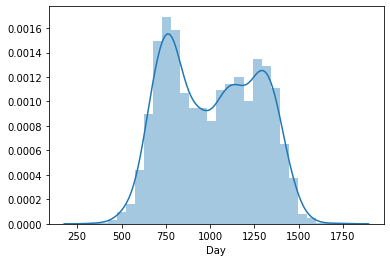

In [17]:
# Viewing distribution of crime occurences of all regularly occurring days
other_days = day_of_month.loc[day_of_month['day_of_month'].isin(some_days)].Day
sns.distplot(other_days)

# Testing if the distribution is normal enough for a t-test
stats.shapiro(other_days)

(0.9591082334518433, 5.58116335014347e-06)

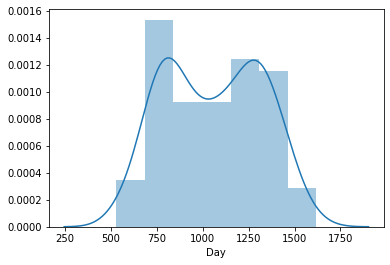

In [18]:
# Viewing distribution of crime occurences on day 15 of month
dist_of_15th = day_of_month.loc[day_of_month['day_of_month'] == '15'].Day
sns.distplot(dist_of_15th)

# Testing if the distribution is normal enough for a t-test
stats.shapiro(dist_of_15th)

In [19]:
# Analyzing the statistical significance of the two groups
stats.ttest_ind(other_days, dist_of_15th)

Ttest_indResult(statistic=-2.5274440733049186, pvalue=0.01151508857004353)

Perhaps due to the semi-monthly pay schedule of Chicago residents, there is an increase in crime on days 1 and 15. The t-test above shows that the difference in day 15 is significant enough when compared to the other days of the month.

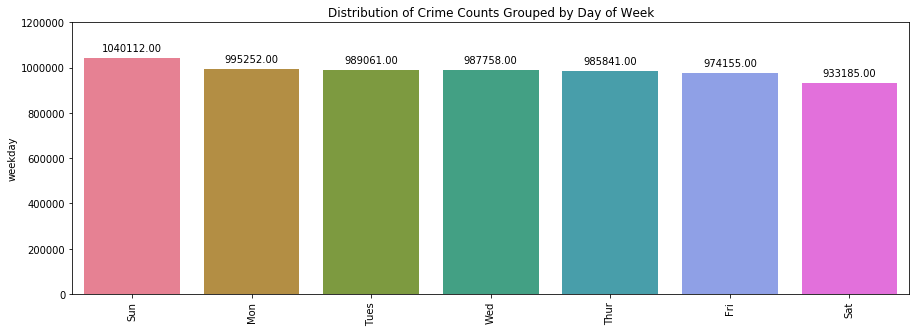

In [20]:
# Setting list to traditional week order
days = ['Sun','Mon','Tues','Wed','Thur','Fri','Sat']

# Plotting crime frequency per day
plt.figure(figsize=[15,5])
ax = sns.barplot(x=df['weekday'].value_counts().reindex(days).index, 
                 y=df['weekday'].value_counts(),
                 palette='husl'
                )
plt.xticks(rotation=90)
plt.title('Distribution of Crime Counts Grouped by Day of Week')

ax.set_ylim(0, 1200000)
for p in ax.patches:
    ax.annotate("%.2f" % p.get_height(), 
                (p.get_x() + p.get_width() / 2., 
                 p.get_height()),
                ha='center', 
                va='center', 
                xytext=(0, 10), 
                textcoords='offset points'
               )
plt.show()

Surprisingly, Saturday is the least active crime day, and, in contrast, Sunday is the most active day. All other days show relative consistency.

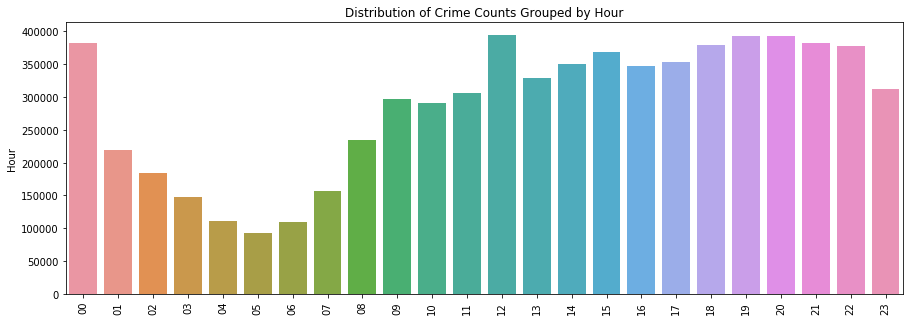

In [21]:
# Plotting frequency of crime per given hour
plt.figure(figsize=[15,5])
g = sns.barplot(x=df['Hour'].value_counts().index, 
                y=df['Hour'].value_counts()
               )
plt.xticks(rotation=90)
plt.title('Distribution of Crime Counts Grouped by Hour')
plt.show()

The most active times for crime in the day are during the evening; however, the most active hour is noon - perhaps this is due to the lunch hour during the typical work day.

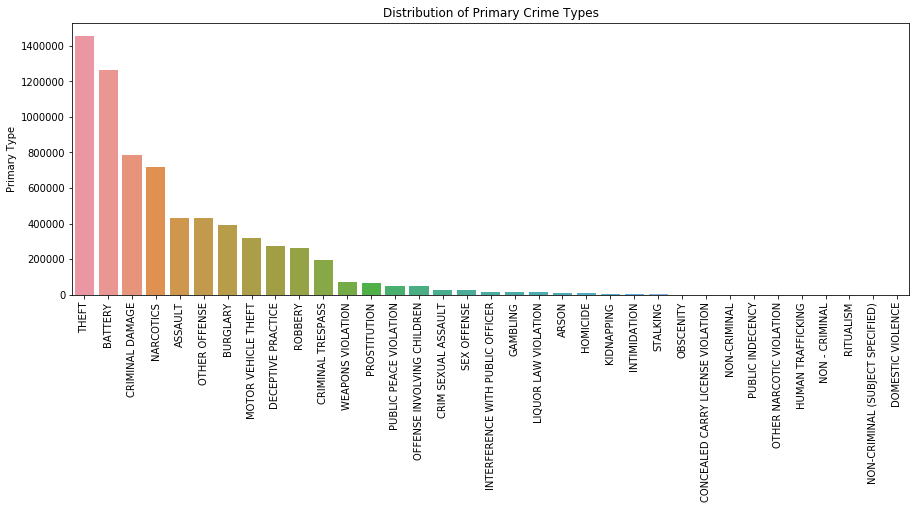

In [22]:
# Plotting frequency of crime types
plt.figure(figsize=[15,5])
g = sns.barplot(x=df['Primary Type'].value_counts().index, 
                y=df['Primary Type'].value_counts()
               )
plt.xticks(rotation=90)
plt.title('Distribution of Primary Crime Types')
plt.show()

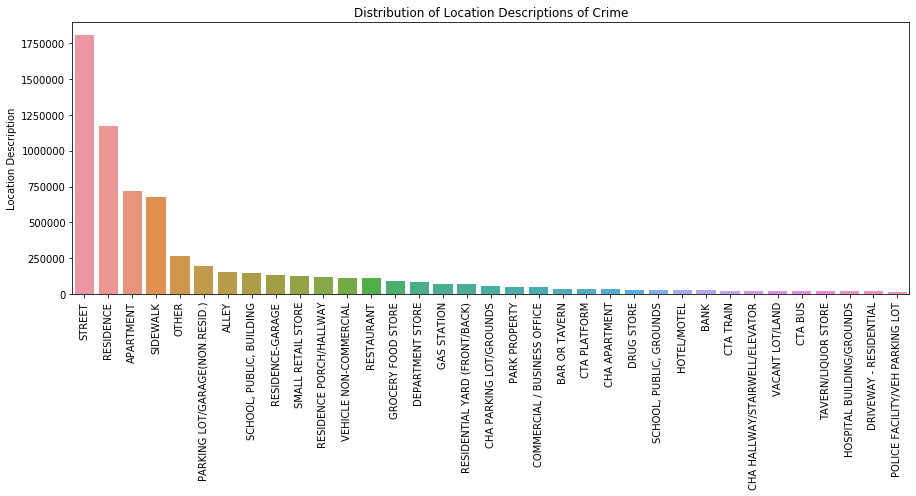

In [23]:
# Plotting frequency of crime location types
plt.figure(figsize=[15,5])
sns.barplot(x=df['Location Description'].value_counts().index[:35], 
            y=df['Location Description'].value_counts()[:35]
           )
plt.xticks(rotation=90)
plt.title('Distribution of Location Descriptions of Crime')
plt.show()

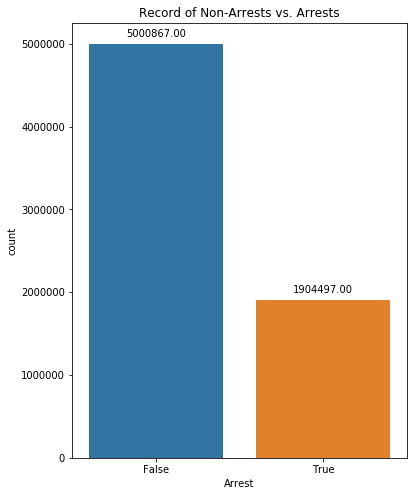

In [24]:
# Comparing non-arrests to arrests
plt.figure(figsize=(6, 8))
g = sns.countplot(df['Arrest'])
for p in g.patches:
    g.annotate(format(p.get_height(), '.2f'), 
               (p.get_x() + p.get_width() / 2., 
                p.get_height()), 
               ha = 'center', 
               va = 'center', 
               xytext = (0, 10), 
               textcoords = 'offset points'
              )
plt.title('Record of Non-Arrests vs. Arrests')
plt.show()

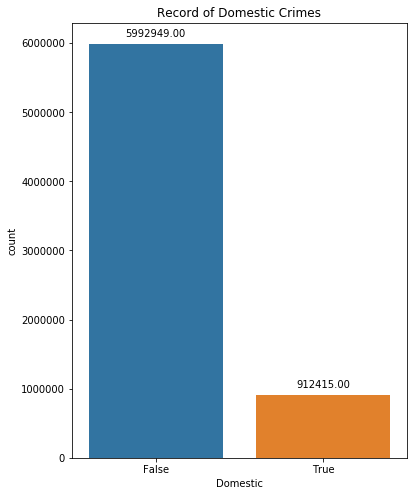

In [25]:
# Comparing non-domestic crimes to domestic crimes
plt.figure(figsize=(6, 8))
g = sns.countplot(df['Domestic'])
for p in g.patches:
    g.annotate(format(p.get_height(), '.2f'), 
               (p.get_x() + p.get_width() / 2., 
                p.get_height()), 
               ha = 'center', 
               va = 'center', 
               xytext = (0, 10), 
               textcoords = 'offset points'
              )
plt.title('Record of Domestic Crimes')
plt.show()

### B. Geographical Analysis

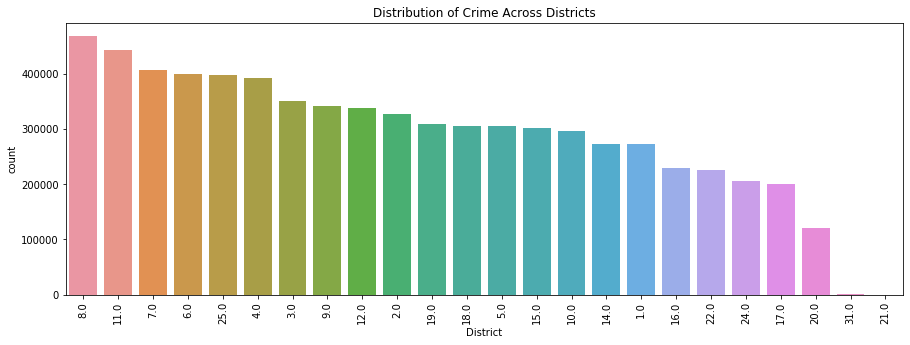

In [26]:
# Viewing crime activity per district
plt.figure(figsize=[15,5])
sns.countplot(x = 'District',
              data = df,
              order = df['District'].value_counts().index
             )
plt.xticks(rotation=90)
plt.title('Distribution of Crime Across Districts')
plt.show()

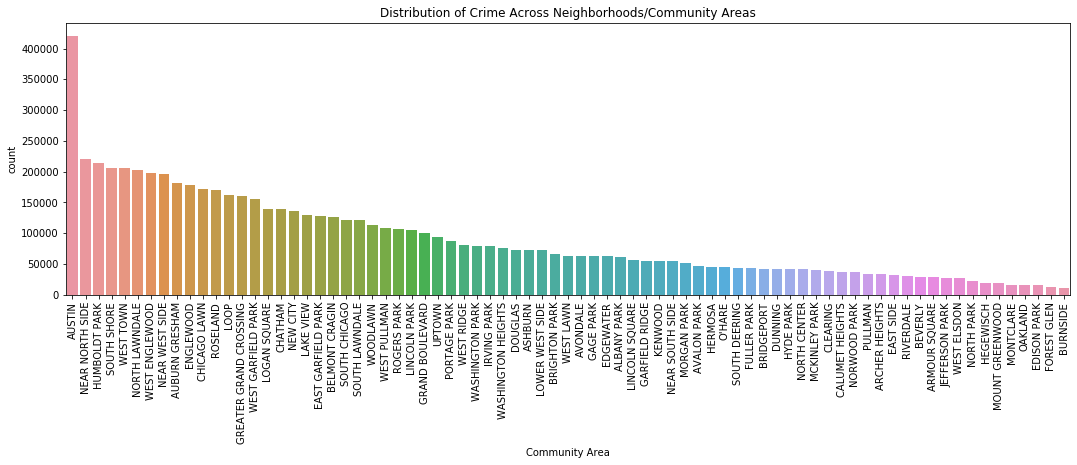

In [27]:
# Viewing crime activity per neighborhood
plt.figure(figsize=[18,5])
sns.countplot(x = 'Community Area',
              data = df,
              order = df['Community Area'].value_counts().index
             )
plt.xticks(rotation=90)
plt.title('Distribution of Crime Across Neighborhoods/Community Areas')
plt.show()

In [28]:
# Removing entries with missing geographical data
geographical_df = df[~df.Location.isna()]

In [29]:
# Empty lists for seperating location into latitude and longitude
latitude = [] # north/south position
longitude = [] # east/west position

# Populating lists with latitude and longitude for geo-plotting
for location in geographical_df.Location:
    latitude.append(float(location[location.find("(")+1:location.find(",")]))
    longitude.append(float(location[location.find(",")+2:location.find(")")]))

geographical_df['Latitude'] = latitude
geographical_df['Longitude'] = longitude

In [30]:
# Removing 168 erroneous instances where geographic location is set to Missouri
missouri = geographical_df.Longitude.min()
geographical_df.drop(geographical_df[geographical_df.Longitude == missouri].index,
                    inplace=True)
geographical_df.shape

(6843025, 31)

In [31]:
# Creating GeoPanda specific feature with geo-data
geometry = [Point(xy) 
            for xy 
            in zip(geographical_df.Longitude, geographical_df.Latitude)
           ]

# Specifying GeoPanda CRS (tells Python how coordinates relate to Earth)
crs = {'init':'epsg:4326'}

# Populating GeoPanda df
geo_df = gpd.GeoDataFrame(geographical_df, #specify data
                         crs = crs, # specify coordinate reference system
                         geometry = geometry #specify geometry list
                         ) 

In [32]:
# Loading shapefile of Chicago
path = 'Neighborhoods/geo_export_56d97edb-1685-4eca-b122-f6a5bb146bb8.shp'
chicago_map = gpd.read_file(path)

C:\ProgramData\Anaconda3\lib\site-packages\geopandas\geodataframe.py:455: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super(GeoDataFrame, self).__getitem__(key)


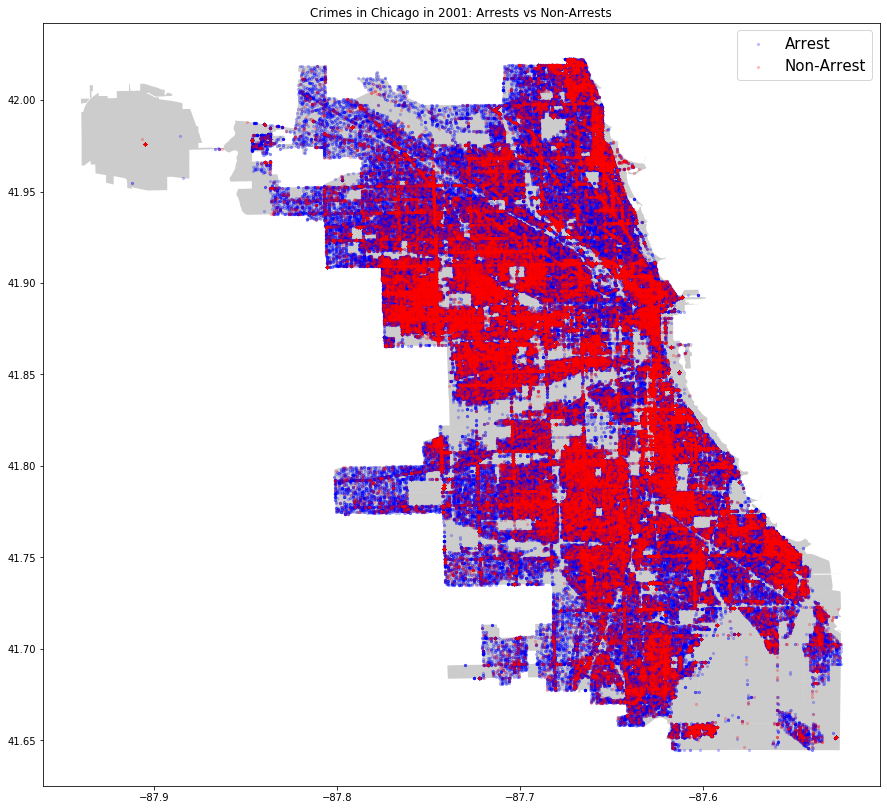

In [33]:
# Plotting map
fig, ax = plt.subplots(figsize=(15,15))
chicago_map.plot(ax=ax, alpha=0.4, color='grey')

# Creating dataframes for plotting
non_arrests = geo_df[geo_df['Arrest'] == False]
arrests = geo_df[geo_df['Arrest'] == True]

# Plotting arrests and non-arrests on map
non_arrests[geo_df['Year'] == 2001].plot(ax=ax, 
                                         markersize=5, 
                                         color='blue', 
                                         marker='o', 
                                         alpha=.2, 
                                         label='Arrest'
                                        )
arrests[geo_df['Year'] == 2001].plot(ax=ax, 
                                     markersize=5, 
                                     color='red', 
                                     marker='o', 
                                     alpha=.2, 
                                     label='Non-Arrest'
                                    )
plt.legend(prop={'size':15})
plt.title('Crimes in Chicago in 2001: Arrests vs Non-Arrests')
plt.show()

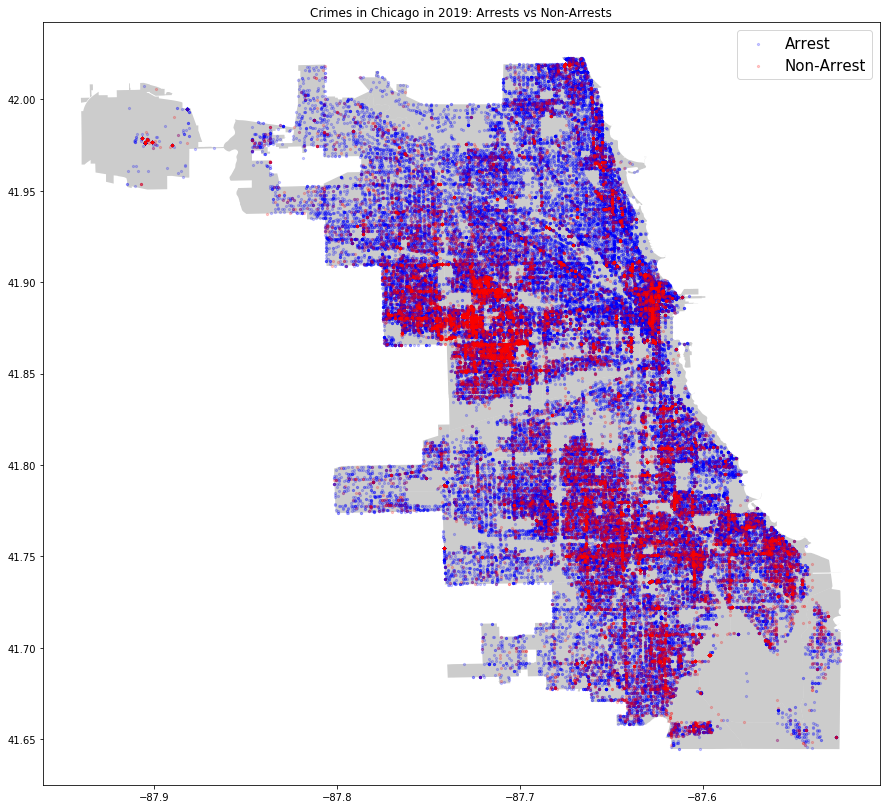

In [34]:
# Plotting map
fig, ax = plt.subplots(figsize=(15,15))
chicago_map.plot(ax=ax, alpha=0.4, color='grey')

# Plotting arrests and non-arrests on map
non_arrests[geo_df['Year'] == 2019].plot(ax=ax, 
                                         markersize=5, 
                                         color='blue', 
                                         marker='o', 
                                         alpha=.2, 
                                         label='Arrest'
                                        )
arrests[geo_df['Year'] == 2019].plot(ax=ax, 
                                     markersize=5, 
                                     color='red', 
                                     marker='o', 
                                     alpha=.2, 
                                     label='Non-Arrest'
                                    )
plt.legend(prop={'size':15})
plt.title('Crimes in Chicago in 2019: Arrests vs Non-Arrests')
plt.show()

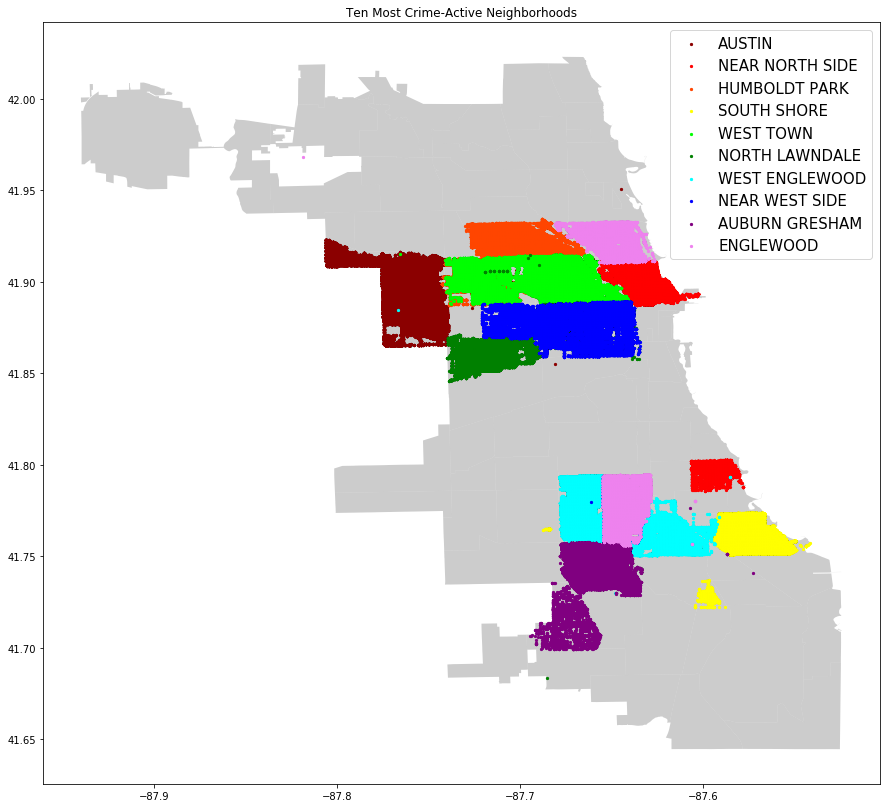

In [35]:
# Isolating ten most dangerous neighborhoods
ten_danger_neighborhoods = df['Community Area'].value_counts().iloc[:10]

# Plotting map
fig, ax = plt.subplots(figsize=(15,15))
chicago_map.plot(ax=ax, alpha=0.4, color='grey')

# Plotting locations
colors = ['darkred','red','orangered','yellow','lime',
          'green','aqua','blue','purple','violet'
         ]
for neighborhood, color in zip(ten_danger_neighborhoods.index, colors):
    ix = geo_df['Community Area'] == neighborhood
    geo_df[ix].plot(ax=ax,
                    markersize=5,
                    color=color, 
                    marker='o', 
                    alpha=1, 
                    label=str(neighborhood)
                   )
plt.legend(prop={'size':15})
plt.title('Ten Most Crime-Active Neighborhoods')
plt.show()

<img src="Neighborhoods/800px-Chicago_community_areas_map.png" alt="neighborhoods" width="600"/>

The following map was created by: Peter Fitzgerald, CC BY-SA 3.0, https://commons.wikimedia.org/w/index.php?

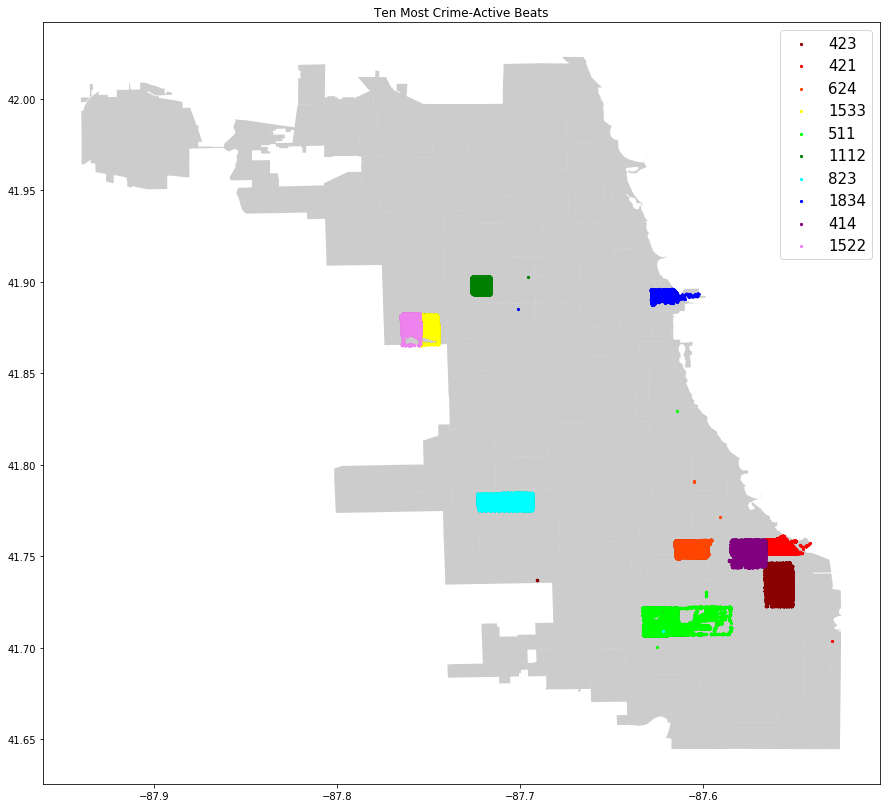

In [36]:
# Isolating ten most dangerous beats
ten_danger_beats = df['Beat'].value_counts().iloc[:10]

# Plotting map
fig, ax = plt.subplots(figsize=(15,15))
chicago_map.plot(ax=ax, alpha=0.4, color='grey')

# Plotting locations
for beat, color in zip(ten_danger_beats.index, colors):
    geo_df[geo_df['Beat'] == beat].plot(ax=ax,
                                         markersize=5,
                                         color=color, 
                                         marker='o', 
                                         alpha=1, 
                                         label=str(beat))
plt.legend(prop={'size':15})
plt.title('Ten Most Crime-Active Beats')
plt.show()

### C. Weather Analysis
The following weather data was taken from the [ASOS Network](https://mesonet.agron.iastate.edu/request/download.phtml?network=IL_ASOS) from Iowa State University. This dataset begins in January of 2000 and continues to the present. The entries were collected from the *[ORD] Chicago O'Hare* station within the network *Illinois ASOS*.
#### i. Preparing Weather Data

In [37]:
# Removing unnecessary features
unnecessary = ['station','vsby','skyc1','skyc2','skyc3',
                'skyc4','skyl1','skyl2','skyl3','skyl4',
                'wxcodes','ice_accretion_1hr','ice_accretion_3hr',
                'ice_accretion_6hr','peak_wind_gust',
                'peak_wind_drct','peak_wind_time', 'metar'
               ]
weather_df = pd.read_csv('Weather Data/ORD.txt').drop(unnecessary, 1)

# Renaming columns
weather_df.columns = (['timestamp','air_temp','dew_pt_temp',
                       'rel_humidity','wind_direction','wind_speed',
                       'precipitation_by_hour','alti_pressure',
                       'sea_level_pressure','wind_gust','real_feel_temp'])

In [38]:
# Creating new feature that only includes date
date_hour = []
for entry in weather_df.timestamp:
    date_hour.append(entry[:13])

# Adding timesplits to DataFrame
weather_df['date_hour'] = date_hour

In [39]:
# Condensing data to hourly records
weather_df = weather_df.groupby(['date_hour']).mean()

# Observing dataset traits
print(weather_df.shape)
weather_df.isna().sum()

(170880, 10)


air_temp                     66
dew_pt_temp                  71
rel_humidity                363
wind_direction             2548
wind_speed                  260
precipitation_by_hour    103767
alti_pressure                46
sea_level_pressure         1073
wind_gust                136772
real_feel_temp              447
dtype: int64

In [40]:
# Adding date feature
date = []
for entry in weather_df.index:
    date.append(entry[:10])
    
weather_df['date'] = date

In [41]:
# Filling missing hours of day with average daily record per feature
for col in weather_df.columns:
    if col == 'date':
        continue
    else:
        weather_df[str(col)] = weather_df.groupby("date")[
            str(col)].transform(lambda x: x.fillna(x.mean()))

In [42]:
# Filling missing values (non-measurable instances equal to zero)
weather_df['precipitation_by_hour'].fillna(0, inplace= True)
weather_df['wind_gust'].fillna(0, inplace= True)

In [43]:
# Missing values are only from last three days 
# (24 hours * 3 days = 72 entries)
weather_df.isnull().sum()

air_temp                  0
dew_pt_temp               0
rel_humidity              0
wind_direction            0
wind_speed                0
precipitation_by_hour     0
alti_pressure             0
sea_level_pressure        0
wind_gust                 0
real_feel_temp           72
date                      0
dtype: int64

#### ii. Merging Weather Data with Crime Data

In [44]:
# Creating mutual feature to merge weather with crime according to date and hour
temporary_merge = weather_df.index
weather_df['merging_date_hour'] = temporary_merge

# Creating mutual feature to merge crime with weather according to date and hour
temp_merge = (df.Year.astype(str) 
                   + '-' 
                   + df.Month.astype(str) 
                   + '-' 
                   + df.Day.astype(str) 
                   + ' ' 
                   + df.Hour.astype(str)
                  )

# Df missing trailing zero: therefore, we add zero for midnight hour
for lacking_zero in temp_merge[temp_merge.str[-2:] == ' 0'].index:
    temp_merge[lacking_zero] = temp_merge[lacking_zero] + '0'
    
df['merging_date_hour'] = temp_merge

In [45]:
# Merging crime and weather DataFrames
df = df.merge(weather_df, 
              how='left', 
              left_on='merging_date_hour', 
              right_on='merging_date_hour'
             )    

# Some hours are missing: filling Nan values with preceding hour information
df[weather_df.columns] = df[weather_df.columns].fillna(method='ffill')

# Removing superfluous joining column
df.drop('merging_date_hour', axis=1, inplace=True)

In [46]:
# Viewing Nan values, specifically regarding weather
df.isnull().sum()

ID                             0
Case Number                    4
Block                          0
IUCR                           0
Primary Type                   0
Description                    0
Location Description        5237
Arrest                         0
Domestic                       0
Beat                           0
District                      47
Ward                      605207
Community Area                 0
X Coordinate               62231
Y Coordinate               62231
Year                           0
Location                   62231
Zip Codes                  62231
Community Areas            78880
Census Tracts              76908
Wards                      78768
Boundaries - ZIP Codes     78836
Police Districts           77860
Police Beats               77837
Month                          0
Day                            0
Hour                           0
Minute                         0
weekday                        0
air_temp                       0
dew_pt_tem

#### iii. Analyzing Interplay Between Crime and Weather

In [47]:
#Creating temperature bins in crime df to categorize continuous temperature
increments_of_five = np.linspace(-55, 115, 35)
df['real_feel_buckets'] = pd.cut(df['real_feel_temp'], 
                                 increments_of_five)

In [48]:
# Creating temperature bins in weather df to count occurences in history
weather_df['real_feel_buckets'] = pd.cut(weather_df['real_feel_temp'], 
                                         increments_of_five)
weather_df.head()

,air_temp,dew_pt_temp,rel_humidity,wind_direction,wind_speed,precipitation_by_hour,alti_pressure,sea_level_pressure,wind_gust,real_feel_temp,date,merging_date_hour,real_feel_buckets
date_hour,,,,,,,,,,,,,
2000-01-01 08,37.40,30.20,74.98,210.000000,8.0,0.0,30.00,1013.333333,0.0,30.77,2000-01-01,2000-01-01 08,"(30.0, 35.0]"
2000-01-01 09,39.92,30.92,69.96,210.000000,4.0,0.0,30.01,1016.900000,0.0,36.67,2000-01-01,2000-01-01 09,"(35.0, 40.0]"
2000-01-01 10,44.06,30.92,59.64,153.333333,6.0,0.0,30.01,1016.500000,0.0,40.05,2000-01-01,2000-01-01 10,"(40.0, 45.0]"
2000-01-01 11,44.96,30.92,57.63,210.000000,6.0,0.0,29.97,1015.400000,0.0,41.14,2000-01-01,2000-01-01 11,"(40.0, 45.0]"
2000-01-01 12,46.04,30.02,53.33,230.000000,5.0,0.0,29.95,1014.800000,0.0,43.07,2000-01-01,2000-01-01 12,"(40.0, 45.0]"


In [49]:
# Removing weather data that precedes available crime data
weather_df = weather_df.drop(weather_df[weather_df.date < min(df.date)].index)

# Crime count and temp count per weather bucket
crimes_per_weather = df.groupby(['real_feel_buckets'])['ID'].count()
temp_per_weather = weather_df.groupby(['real_feel_buckets']
                                     )['merging_date_hour'].count()

In [50]:
# Quantifying probability of crime per hour given temperature within hour
crimes_per_occurence = crimes_per_weather / temp_per_weather

In [51]:
# Creating DataFrame for easy manipulation
crime_weather_df = pd.DataFrame(crimes_per_occurence, 
                                columns=['crimes_per_occurence']
                               )
crime_weather_df.reset_index(level=0, inplace=True)

# Changing column to string for later modeling
temp_string = crime_weather_df.real_feel_buckets.astype(str)
crime_weather_df.real_feel_buckets = temp_string

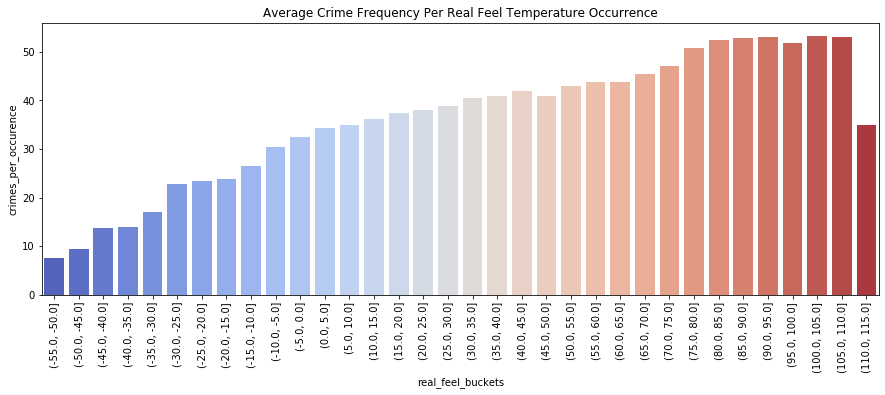

,real_feel_buckets,crimes_per_occurence
24,"(65.0, 70.0]",45.433394
25,"(70.0, 75.0]",47.056282
26,"(75.0, 80.0]",50.773882
27,"(80.0, 85.0]",52.310580
28,"(85.0, 90.0]",52.757576
29,"(90.0, 95.0]",52.968542
30,"(95.0, 100.0]",51.898132
31,"(100.0, 105.0]",53.253807
32,"(105.0, 110.0]",53.000000
33,"(110.0, 115.0]",35.000000


In [52]:
# Plotting Crime Frequency per Real Feel Temperature occurrence
plt.figure(figsize=[15,5])
sns.barplot(x='real_feel_buckets', 
            y='crimes_per_occurence', 
            data=crime_weather_df, 
            palette="coolwarm"
           )
plt.xticks(rotation=90)
plt.title('Average Crime Frequency Per Real Feel Temperature Occurrence')
plt.show()

crime_weather_df.tail(10)

To briefly explain the chart above, the crimes were binned according to their real feel temperature at the time of the crime and the temperature occurrences were binned according to their real feel temperature frequency. To provide an example, cold hours like the far left were infrequent (as can be seen in `temp_occurences_per_weather_bucket` - there are only 2 temperature recordings since 2001) and the crimes recorded during an hour where the temperature fell within this bin was correlatingly infrequent (with only 15 crimes reported during these two hours - as can be seen in `crimes_per_weather_bucket`) meaning that, on average, in a given hour where the temperature fell between -50 and -55 degrees only 7.5 crimes were committed. 

This explained, it is jarringly apparent that there is a causal relationship of temperature on crime frequency.

In [53]:
# Creating bins in df to categorize continuous variable precipiation
increments_of_fourth = np.linspace(0, 2.5, 11)
df['precipitation_buckets'] = pd.cut(df['precipitation_by_hour'], 
                                     increments_of_fourth, 
                                     include_lowest=True)

In [54]:
# Creating bins in weather df to count number of occurences in history
weather_df['precipitation_buckets'] = pd.cut(weather_df['precipitation_by_hour'],
                                             increments_of_fourth, 
                                             include_lowest=True)
weather_df.head()

,air_temp,dew_pt_temp,rel_humidity,wind_direction,wind_speed,precipitation_by_hour,alti_pressure,sea_level_pressure,wind_gust,real_feel_temp,date,merging_date_hour,real_feel_buckets,precipitation_buckets
date_hour,,,,,,,,,,,,,,
2001-01-01 00,12.02,10.04,91.57,10.0,5.0,0.0,30.33,1028.2,0.0,2.67,2001-01-01,2001-01-01 00,"(0.0, 5.0]","(-0.001, 0.25]"
2001-01-01 01,12.92,10.94,91.61,360.0,4.0,0.0,30.34,1028.5,0.0,5.14,2001-01-01,2001-01-01 01,"(5.0, 10.0]","(-0.001, 0.25]"
2001-01-01 02,12.92,10.04,88.00,340.0,4.0,0.0,30.35,1028.9,0.0,5.14,2001-01-01,2001-01-01 02,"(5.0, 10.0]","(-0.001, 0.25]"
2001-01-01 03,8.96,6.98,91.45,330.0,4.0,0.0,30.36,1029.2,0.0,0.52,2001-01-01,2001-01-01 03,"(0.0, 5.0]","(-0.001, 0.25]"
2001-01-01 04,10.04,8.06,91.49,320.0,3.0,0.0,30.35,1029.2,0.0,3.58,2001-01-01,2001-01-01 04,"(0.0, 5.0]","(-0.001, 0.25]"


In [55]:
# Counting occurence of crime and temperature per weather bucket
crimes_per_precipitation = df.groupby(['precipitation_buckets'])['ID'].count()
precipitation_per_weather = weather_df.groupby(['precipitation_buckets']
                                              )['merging_date_hour'].count()

In [56]:
# Quantifying probability of crime per hour given precipitation occurrence
crimes_per_prec_occurence = crimes_per_precipitation/precipitation_per_weather

In [57]:
# Creating DataFrame for easy manipulation
crime_rain_df = pd.DataFrame(crimes_per_prec_occurence, 
                             columns=['crimes_per_prec_occurence']
                            )
crime_rain_df.reset_index(level=0, inplace=True)

# Changing column to string for later modeling
temp_string = crime_rain_df.precipitation_buckets.astype(str)
crime_rain_df.precipitation_buckets = temp_string

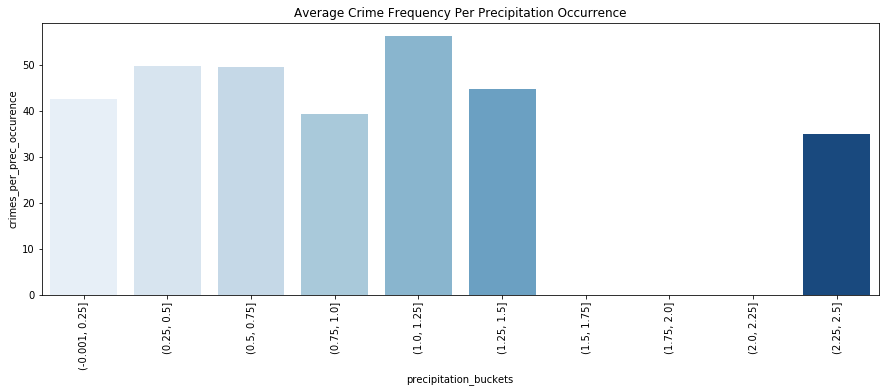

,precipitation_buckets,crimes_per_prec_occurence
0,"(-0.001, 0.25]",42.521198
1,"(0.25, 0.5]",49.660279
2,"(0.5, 0.75]",49.540541
3,"(0.75, 1.0]",39.250000
4,"(1.0, 1.25]",56.269231
5,"(1.25, 1.5]",44.666667
6,"(1.5, 1.75]",NaN
7,"(1.75, 2.0]",NaN
8,"(2.0, 2.25]",NaN
9,"(2.25, 2.5]",35.000000


In [58]:
# Plotting Crime Frequency per Real Feel Temperature occurrence
plt.figure(figsize=[15,5])
sns.barplot(x='precipitation_buckets', 
            y='crimes_per_prec_occurence', 
            data=crime_rain_df, 
            palette="Blues"
           )
plt.xticks(rotation=90)
plt.title('Average Crime Frequency Per Precipitation Occurrence')
plt.show()

crime_rain_df.tail(10)

## Section 4: Modeling

The models will consist of predicting **daily** crime:
1. For the city as a whole
2. For the individual neighborhoods

### A. Predicting Total Daily Crimes for City as a Whole

In [59]:
# Creating DataFrame for initial model of crime per hour prediction in Chicago
city_day_df = df.groupby('date').agg({'Year':'first',
                                            'Month':'first',
                                            'Day':'first',
                                            'weekday':'first',
                                            'ID':'count',
                                            'Arrest':'sum',
                                            'air_temp': 'first',
                                            'real_feel_temp': 'first',
                                            'dew_pt_temp':'first',
                                            'rel_humidity': 'first',
                                            'wind_speed': 'first',
                                            'wind_direction': 'first',
                                            'precipitation_by_hour': 'first',
                                            'alti_pressure': 'first',
                                            'sea_level_pressure': 'first',
                                            'wind_gust': 'first'}
                                    )

# Renaming target column
city_day_df = city_day_df.rename(columns = {'ID':'crimes_per_day'})

# Changing "Year" column to categorical
city_day_df['Year'] = city_day_df.Year.astype(str)

# Making dummies
city_day_df = pd.get_dummies(city_day_df, 
                             prefix=['year','month','day','wkday'])

# Previewing
city_day_df.head()

,crimes_per_day,Arrest,air_temp,real_feel_temp,dew_pt_temp,rel_humidity,wind_speed,wind_direction,precipitation_by_hour,alti_pressure,sea_level_pressure,wind_gust,year_2001,year_2002,year_2003,year_2004,year_2005,year_2006,year_2007,year_2008,year_2009,year_2010,year_2011,year_2012,year_2013,year_2014,year_2015,year_2016,year_2017,year_2018,year_2019,month_01,month_02,month_03,month_04,month_05,month_06,month_07,month_08,month_09,month_10,month_11,month_12,day_01,day_02,day_03,day_04,day_05,day_06,day_07,day_08,day_09,day_10,day_11,day_12,day_13,day_14,day_15,day_16,day_17,day_18,day_19,day_20,day_21,day_22,day_23,day_24,day_25,day_26,day_27,day_28,day_29,day_30,day_31,wkday_Fri,wkday_Mon,wkday_Sat,wkday_Sun,wkday_Thur,wkday_Tues,wkday_Wed
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2001-01-01,1807,393.0,9.32,-2.320,6.44,87.915,6.5,315.0,0.0,30.505,1034.40,0.000000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2001-01-02,1139,380.0,8.33,-8.440,3.11,78.810,12.5,225.0,0.0,30.365,1029.55,0.000000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2001-01-03,1149,342.0,28.22,20.975,23.99,84.020,6.0,320.0,0.0,30.060,1018.90,18.375000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2001-01-04,1166,377.0,29.57,19.655,24.44,80.935,10.5,245.0,0.0,29.530,1000.70,19.333333,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2001-01-05,1261,415.0,22.10,12.775,14.54,72.280,7.0,275.0,0.0,29.840,1011.25,20.583333,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


In [60]:
# Creating holdout
training, holdout = train_test_split(city_day_df, 
                                     test_size=0.2, 
                                     random_state=0
                                    )

# Creating feature and target variables
X = training.drop(['crimes_per_day','Arrest'], 1)
X = (X - X.mean()) / (X.max() - X.min())           #normalizing
y = training.crimes_per_day

# Creating train-test split
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state=0)

0.9155262847639105


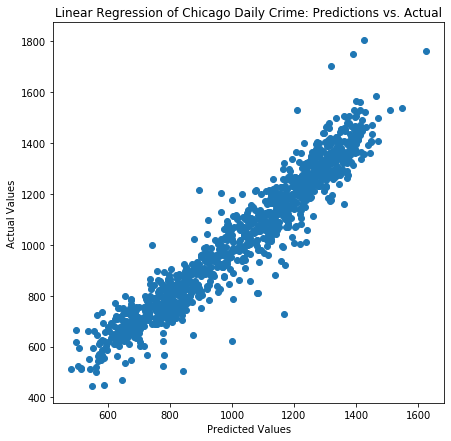

In [61]:
regr = LinearRegression()
regr.fit(X_train, y_train)
print(regr.score(X_test, y_test))

plt.figure(figsize=[7,7])
pred = regr.predict(X_test)
plt.scatter(pred, y_test)
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Linear Regression of Chicago Daily Crime: Predictions vs. Actual')
plt.show()

In [62]:
lasso = Lasso()
lasso.fit(X_train, y_train)
lasso.score(X_test, y_test)

0.9049069202021626

In [63]:
ridge = Ridge()
ridge.fit(X_train, y_train)
ridge.score(X_test, y_test)

0.9153026817971599

In [64]:
# Viewing most valuable coefficients in Ridge
coefficients = pd.DataFrame({'name': X.columns, 'coef': ridge.coef_})
print(coefficients.sort_values('coef', ascending=False).head(10))
print(coefficients.sort_values('coef', ascending=False).tail(10))

           name        coef
10    year_2001  304.009914
12    year_2003  299.102771
11    year_2002  295.275457
13    year_2004  267.341359
2   dew_pt_temp  223.799100
14    year_2005  221.827544
15    year_2006  208.876353
41       day_01  203.894593
16    year_2007  178.174766
17    year_2008  159.395999
                     name        coef
3            rel_humidity  -77.124284
21              year_2012 -105.845700
6   precipitation_by_hour -108.106932
22              year_2013 -167.624663
23              year_2014 -247.129730
27              year_2018 -278.969263
25              year_2016 -280.430432
26              year_2017 -287.832074
24              year_2015 -289.103535
28              year_2019 -304.021261


In [65]:
rfr = RandomForestRegressor(n_estimators=10, random_state=0)
rfr.fit(X_train, y_train)
rfr.score(X_test, y_test)

0.9024536309995677

In [66]:
nn = MLPRegressor(learning_rate_init=0.01, max_iter=2000, random_state=0)
nn.fit(X_train, y_train)
nn.score(X_test, y_test)

0.9184431429378076

### B. Predicting Daily Crime per Specified Neighborhood

In [67]:
# Creating DataFrame for initial model of crime per hour prediction in Chicago
neighborhood_day_df = df.groupby(['date','Community Area']).agg({'Year':'first',
                                            'Month':'first',
                                            'Day':'first',
                                            'weekday':'first',
                                            'ID':'count',
                                            'Arrest':'sum',
                                            'air_temp': 'first',
                                            'real_feel_temp': 'first',
                                            'dew_pt_temp':'first',
                                            'rel_humidity': 'first',
                                            'wind_speed': 'first',
                                            'wind_direction': 'first',
                                            'precipitation_by_hour': 'first',
                                            'alti_pressure': 'first',
                                            'sea_level_pressure': 'first',
                                            'wind_gust': 'first'})

# Making index into feature
neighborhood_day_df.reset_index(level=['Community Area'], inplace=True)

# Renaming target column
neighborhood_day_df=neighborhood_day_df.rename(columns={'ID':'crimes_per_day'})

# Changing "Year" column to categorical
neighborhood_day_df['Year'] = neighborhood_day_df.Year.astype(str)

# Making dummies
neighborhood_day_df = pd.get_dummies(neighborhood_day_df, 
                                     prefix=['neighborhood',
                                             'year', 
                                             'month',
                                             'day',
                                             'wkday']
                                    )

# Previewing
neighborhood_day_df.head()

,crimes_per_day,Arrest,air_temp,real_feel_temp,dew_pt_temp,rel_humidity,wind_speed,wind_direction,precipitation_by_hour,alti_pressure,sea_level_pressure,wind_gust,neighborhood_ALBANY PARK,neighborhood_ARCHER HEIGHTS,neighborhood_ARMOUR SQUARE,neighborhood_ASHBURN,neighborhood_AUBURN GRESHAM,neighborhood_AUSTIN,neighborhood_AVALON PARK,neighborhood_AVONDALE,neighborhood_BELMONT CRAGIN,neighborhood_BEVERLY,neighborhood_BRIDGEPORT,neighborhood_BRIGHTON PARK,neighborhood_BURNSIDE,neighborhood_CALUMET HEIGHTS,neighborhood_CHATHAM,neighborhood_CHICAGO LAWN,neighborhood_CLEARING,neighborhood_DOUGLAS,neighborhood_DUNNING,neighborhood_EAST GARFIELD PARK,neighborhood_EAST SIDE,neighborhood_EDGEWATER,neighborhood_EDISON PARK,neighborhood_ENGLEWOOD,neighborhood_FOREST GLEN,neighborhood_FULLER PARK,neighborhood_GAGE PARK,neighborhood_GARFIELD RIDGE,neighborhood_GRAND BOULEVARD,neighborhood_GREATER GRAND CROSSING,neighborhood_HEGEWISCH,neighborhood_HERMOSA,neighborhood_HUMBOLDT PARK,neighborhood_HYDE PARK,neighborhood_IRVING PARK,neighborhood_JEFFERSON PARK,neighborhood_KENWOOD,neighborhood_LAKE VIEW,neighborhood_LINCOLN PARK,neighborhood_LINCOLN SQUARE,neighborhood_LOGAN SQUARE,neighborhood_LOOP,neighborhood_LOWER WEST SIDE,neighborhood_MCKINLEY PARK,neighborhood_MONTCLARE,neighborhood_MORGAN PARK,neighborhood_MOUNT GREENWOOD,neighborhood_NEAR NORTH SIDE,neighborhood_NEAR SOUTH SIDE,neighborhood_NEAR WEST SIDE,neighborhood_NEW CITY,neighborhood_NORTH CENTER,neighborhood_NORTH LAWNDALE,neighborhood_NORTH PARK,neighborhood_NORWOOD PARK,neighborhood_O'HARE,neighborhood_OAKLAND,neighborhood_PORTAGE PARK,neighborhood_PULLMAN,neighborhood_RIVERDALE,neighborhood_ROGERS PARK,neighborhood_ROSELAND,neighborhood_SOUTH CHICAGO,neighborhood_SOUTH DEERING,neighborhood_SOUTH LAWNDALE,neighborhood_SOUTH SHORE,neighborhood_UPTOWN,neighborhood_WASHINGTON HEIGHTS,neighborhood_WASHINGTON PARK,neighborhood_WEST ELSDON,neighborhood_WEST ENGLEWOOD,neighborhood_WEST GARFIELD PARK,neighborhood_WEST LAWN,neighborhood_WEST PULLMAN,neighborhood_WEST RIDGE,neighborhood_WEST TOWN,neighborhood_WOODLAWN,year_2001,year_2002,year_2003,year_2004,year_2005,year_2006,year_2007,year_2008,year_2009,year_2010,year_2011,year_2012,year_2013,year_2014,year_2015,year_2016,year_2017,year_2018,year_2019,month_01,month_02,month_03,month_04,month_05,month_06,month_07,month_08,month_09,month_10,month_11,month_12,day_01,day_02,day_03,day_04,day_05,day_06,day_07,day_08,day_09,day_10,day_11,day_12,day_13,day_14,day_15,day_16,day_17,day_18,day_19,day_20,day_21,day_22,day_23,day_24,day_25,day_26,day_27,day_28,day_29,day_30,day_31,wkday_Fri,wkday_Mon,wkday_Sat,wkday_Sun,wkday_Thur,wkday_Tues,wkday_Wed
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2001-01-01,22,5.0,9.32,-2.32,6.44,87.915,6.5,315.0,0.0,30.505,1034.4,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2001-01-01,32,6.0,15.98,3.59,10.04,76.980,9.0,320.0,0.0,30.470,1033.2,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2001-01-01,14,8.0,10.94,0.17,6.98,83.710,6.0,310.0,0.0,30.490,1034.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2001-01-01,37,10.0,9.32,-2.32,6.44,87.915,6.5,315.0,0.0,30

In [68]:
# Creating holdout
training, holdout = train_test_split(neighborhood_day_df, 
                                     test_size=0.2, 
                                     random_state=0)

# Creating feature and target variables
X = training.drop(['crimes_per_day','Arrest'], 1)
y = training.crimes_per_day

# Creating train-test split
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state=0)

In [69]:
regr = LinearRegression()
regr.fit(X_train, y_train)
regr.score(X_test, y_test)

0.735282049929236

In [70]:
lasso = Lasso()
lasso.fit(X_train, y_train)
lasso.score(X_test, y_test)

0.031010058018906

In [71]:
ridge = Ridge()
ridge.fit(X_train, y_train)
ridge.score(X_test, y_test)

0.735280301148749

In [72]:
svr = LinearSVR(max_iter=2000, tol=.001, random_state=0)
svr.fit(X_train, y_train)
svr.score(X_test, y_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.6041867523390707

0.8627029564933079


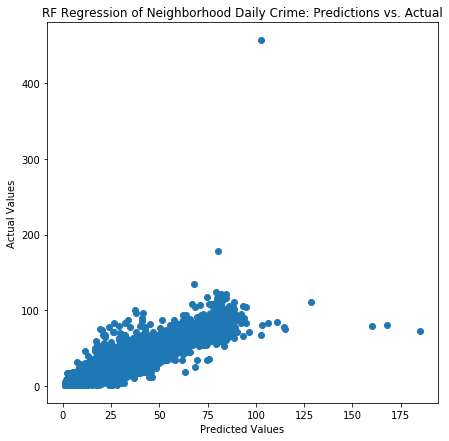

In [73]:
rfr = RandomForestRegressor(n_estimators=100, random_state=0)
rfr.fit(X_train, y_train)
print(rfr.score(X_test, y_test))

plt.figure(figsize=[7,7])
pred = rfr.predict(X_test)
plt.scatter(pred, y_test)
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('RF Regression of Neighborhood Daily Crime: Predictions vs. Actual')
plt.show()

0.846723055725261


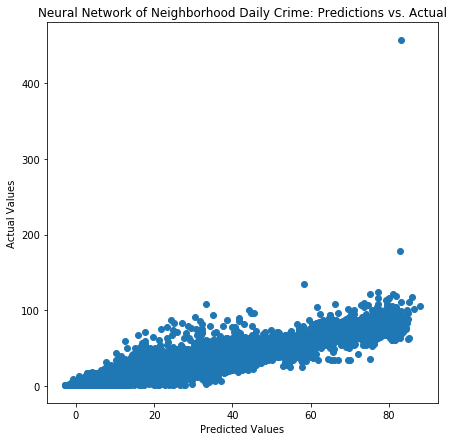

In [74]:
nn = MLPRegressor(learning_rate_init=0.01, max_iter=2000, random_state=0)
nn.fit(X_train, y_train)
print(nn.score(X_test, y_test))

plt.figure(figsize=[7,7])
pred = nn.predict(X_test)
plt.scatter(pred, y_test)
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Neural Network of Neighborhood Daily Crime: Predictions vs. Actual')
plt.show()

## Section 5: Tuning Models

### A. Predicting Total Daily Crimes for City as a Whole

In [75]:
# Creating holdout
training, holdout = train_test_split(city_day_df, 
                                     test_size=0.2, 
                                     random_state=0)

# Creating feature and target variables
X = training.drop(['crimes_per_day','Arrest'], 1)
y = training.crimes_per_day

# Creating train-test split
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state=0)

In [76]:
# prepare a range of alpha values to test
alphas = np.array([1,0.1,0.01,0.001,0.0001,0])

# Fitting the model for Grid Search
ridge = Ridge()
ridge_search = GridSearchCV(cv=5,
                            estimator=ridge, 
                            param_grid=dict(alpha=alphas)
                           )

# Fit the search model
ridge_search.fit(X_train, y_train)

# Returning best parameters
ridge_search.best_params_

{'alpha': 0.01}

In [77]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    return accuracy

# Assessing original model
base_model = Ridge()
base_model.fit(X_train, y_train)
base_accuracy = evaluate(base_model, X_test, y_test)

# Assessing tuned model
best_grid = ridge_search.best_estimator_
search_accuracy = evaluate(best_grid, X_test, y_test)

# Assessing improvement
improvement = (search_accuracy - base_accuracy) / base_accuracy
print('Improvement of {:0.2f}%.'.format(100*(improvement)))

Model Performance
Average Error: 56.2911 degrees.
Accuracy = 94.15%.
Model Performance
Average Error: 56.2152 degrees.
Accuracy = 94.16%.
Improvement of 0.01%.


### B. Predicting Daily Crime per Specified Neighborhood

In [78]:
# Creating holdout
training, holdout = train_test_split(neighborhood_day_df, 
                                     test_size=0.2, 
                                     random_state=0)

tuning_sample = training.sample(frac=0.10, random_state=0)

# Creating feature and target variables
X = tuning_sample.drop(['crimes_per_day','Arrest'], 1)
y = tuning_sample.crimes_per_day

# Creating train-test split
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state=0)

In [79]:
# Defining RFR hyperparameters
n_estimators = [int(x) for x in np.linspace(start = 200, 
                                            stop = 2000, 
                                            num = 10)
               ]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

# Fitting the model
rfr = RandomForestRegressor(random_state=0)
rfr_random = RandomizedSearchCV(estimator = rfr, 
                                param_distributions = random_grid, 
                                n_iter = 10, 
                                cv = 3, 
                                verbose=2, 
                                random_state=0, 
                                n_jobs = -1)

# Fit the random search model
rfr_random.fit(X_train, y_train)

# Returning best parameters
rfr_random.best_params_

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 111.6min finished


{'n_estimators': 800,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'max_depth': 100,
 'bootstrap': True}

In [102]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    return accuracy

# Assessing original model
base_model = RandomForestRegressor(n_estimators= 10, random_state = 0)
base_model.fit(X_train, y_train)
base_accuracy = evaluate(base_model, X_test, y_test)

# Assessing tuned model
best_random = rfr_random.best_estimator_
random_accuracy = evaluate(best_random, X_test, y_test)

# Assessing improvement
improvement = (random_accuracy - base_accuracy) / base_accuracy
print('Improvement of {:0.2f}%.'.format(100*(improvement)))

Model Performance
Average Error: 2.0280 degrees.
Accuracy = 41.54%.
Model Performance
Average Error: 2.0156 degrees.
Accuracy = 44.22%.
Improvement of -1.58%.


In [103]:
# Creating holdout
training, holdout = train_test_split(neighborhood_day_df, 
                                     test_size=0.2, 
                                     random_state=0)

# Creating feature and target variables
X = training.drop(['crimes_per_day','Arrest'], 1)
y = training.crimes_per_day

# Creating train-test split
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state=0)

In [104]:
# Defining RFR hyperparameters
hidden_layer_sizes  = [(100,), (100,10), (50,50), (100,50)]
alpha = [0.01, 0.001, 0.0001, 0.00001]

# Create the random grid
grid = {'hidden_layer_sizes': hidden_layer_sizes,
        'alpha': alpha}

# Fitting the model
mlp = MLPRegressor(random_state=0)
mlp_search = GridSearchCV(estimator = mlp, 
                          param_grid = grid, 
                          n_jobs = -1, 
                          cv = 3, 
                          verbose=2)

# Fit the random search model
mlp_search.fit(X_train, y_train)

# Returning best parameters
mlp_search.best_params_

Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 109.0min
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed: 179.0min finished


{'alpha': 0.001, 'hidden_layer_sizes': (50, 50)}

In [105]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    return accuracy

# Assessing original model
base_model = MLPRegressor(random_state = 0)
base_model.fit(X_train, y_train)
base_accuracy = evaluate(base_model, X_test, y_test)

# Assessing tuned model
best_search = mlp_search.best_estimator_
search_accuracy = evaluate(best_search, X_test, y_test)

# Assessing improvement
improvement = (search_accuracy - base_accuracy) / base_accuracy
print('Improvement of {:0.2f}%.'.format(100*(improvement)))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Model Performance
Average Error: 3.2388 degrees.
Accuracy = 51.06%.
Model Performance
Average Error: 3.5345 degrees.
Accuracy = 44.01%.
Improvement of -13.81%.


## Section 6: Testing on Holdout

### A. Calculating Total Daily Crimes for City as a Whole

In [83]:
# Creating holdout
training, holdout = train_test_split(city_day_df, 
                                     test_size=0.2, 
                                     random_state=0)

# Creating feature and target variables
X = training.drop(['crimes_per_day','Arrest'], 1)
y = training.crimes_per_day

# Creating train-test split
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state=0)

X_holdout = holdout.drop(['crimes_per_day','Arrest'], 1)
y_holdout = holdout.crimes_per_day

0.9148678391928278


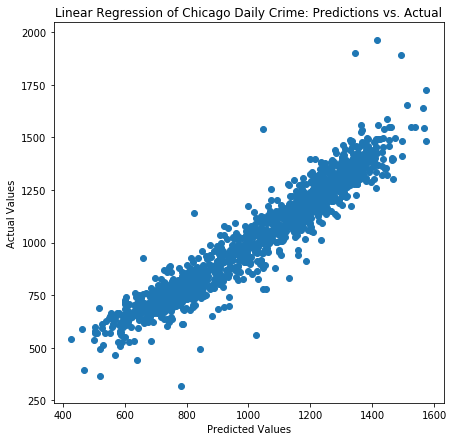

In [84]:
regr = LinearRegression()
regr.fit(X_train, y_train)
print(regr.score(X_holdout, y_holdout))

plt.figure(figsize=[7,7])
pred = regr.predict(X_holdout)
plt.scatter(pred, y_holdout)
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Linear Regression of Chicago Daily Crime: Predictions vs. Actual')
plt.show()

0.9148819222999828


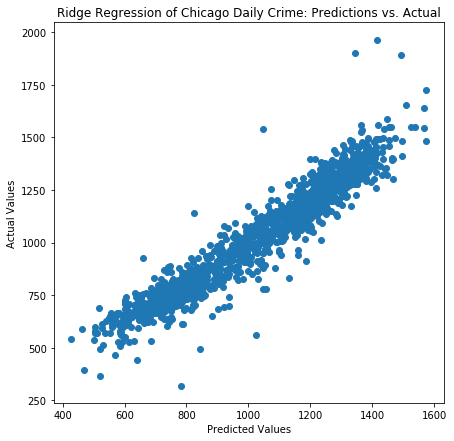

In [85]:
ridge = Ridge(alpha=.01)
ridge.fit(X_train, y_train)
print(ridge.score(X_holdout, y_holdout))

plt.figure(figsize=[7,7])
pred = ridge.predict(X_holdout)
plt.scatter(pred, y_holdout)
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Ridge Regression of Chicago Daily Crime: Predictions vs. Actual')
plt.show()

In [86]:
mean_absolute_error(y_holdout, pred)

54.6340359466922

### B. Calculating Daily Crime per Specified Neighborhood

In [87]:
# Creating holdout
training, holdout = train_test_split(neighborhood_day_df, 
                                     test_size=0.2, 
                                     random_state=0)

# Creating feature and target variables
X = training.drop(['crimes_per_day','Arrest'], 1)
y = training.crimes_per_day

# Creating train-test split
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state=0)

X_holdout = holdout.drop(['crimes_per_day','Arrest'], 1)
y_holdout = holdout.crimes_per_day

0.8688381474720029


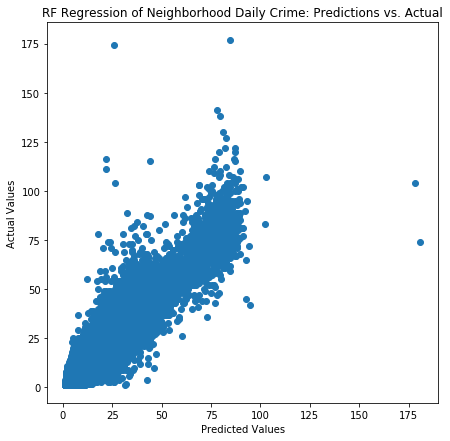

In [88]:
# Importing parameters from RandomSearchCV
rfr = RandomForestRegressor(n_estimators=800, 
                            min_samples_split=2, 
                            min_samples_leaf=2, 
                            max_features='auto',
                            max_depth=100, 
                            bootstrap=True, 
                            random_state=0)
rfr.fit(X_train, y_train)
print(rfr.score(X_holdout, y_holdout))

plt.figure(figsize=[7,7])
pred = rfr.predict(X_holdout)
plt.scatter(pred, y_holdout)
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('RF Regression of Neighborhood Daily Crime: Predictions vs. Actual')
plt.show()

0.8498953069048041


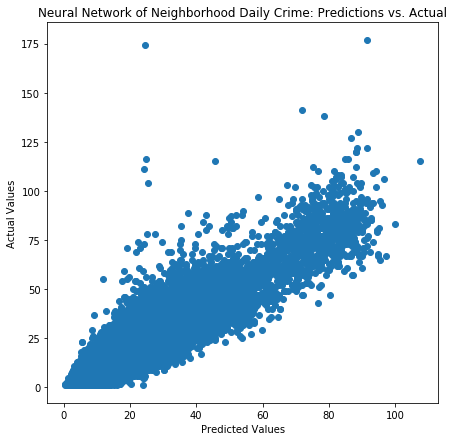

In [106]:
# Importing parameters from GridSearchCV
nn = MLPRegressor(alpha=0.001, hidden_layer_sizes=(50, 50), random_state=0)
nn.fit(X_train, y_train)
print(nn.score(X_holdout, y_holdout))

plt.figure(figsize=[7,7])
pred = nn.predict(X_holdout)
plt.scatter(pred, y_holdout)
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Neural Network of Neighborhood Daily Crime: Predictions vs. Actual')
plt.show()

After modeling the different datasets of city versus neighborhood, there is considerably more difficulty in predicting the smaller geographical areas. However, for the neighborhood model, the predictability of daily crime still floats above the expected 85% accuracy at 86.89% while the predictability of daily crime in the city as a whole remains comfortably at 91.87%.